## Домашнее задание к Уроку 3

In [1]:
import numpy as np
import pandas as pd
import itertools

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, log_loss

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [7]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Users\vladuz\AppData\Local\Temp\ipykernel_22072\2324205212.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('train_case2.csv', ';')


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\vladuz\AppData\Local\Temp\ipykernel_22072\1317150810.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [10]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [11]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [12]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

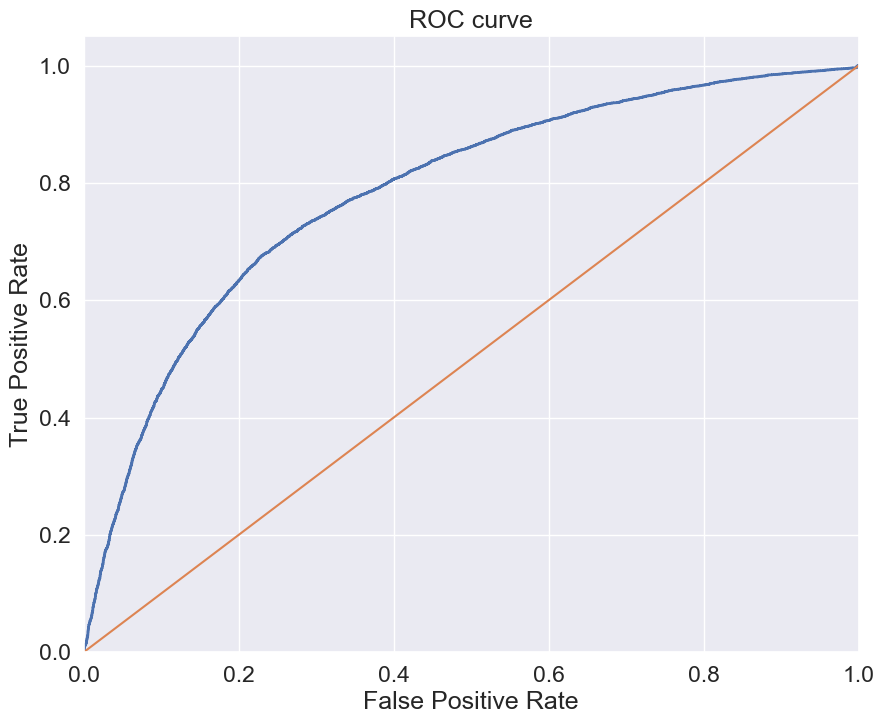

In [13]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [14]:
#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230662


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


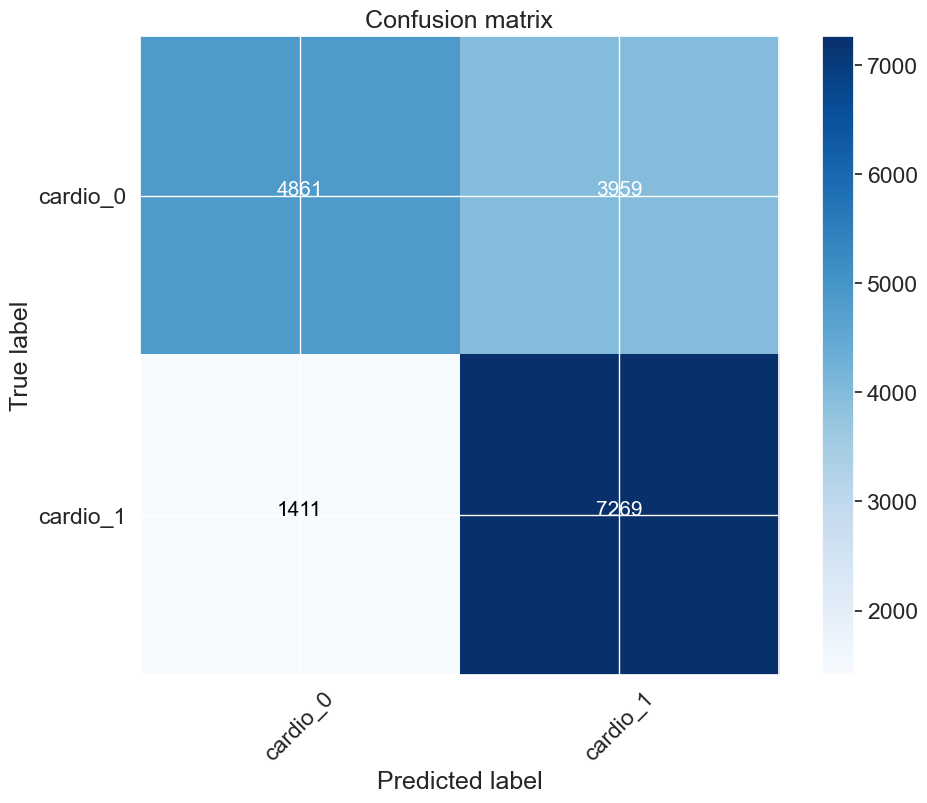

In [15]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [16]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

## Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

#### Модель Logistic Regression

In [17]:
classifier_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_lr = cross_val_score(classifier_lr, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_lr = np.mean(cv_scores_lr)
cv_score_std_lr = np.std(cv_scores_lr)
print('CV score is {}+-{}'.format(cv_score_lr, cv_score_std_lr))

#обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score_lr = classifier_lr.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [18]:
b=1
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.values, y_score)
fscore_lr = (1+b**2)*(precision_lr * recall_lr) / (b**2*precision_lr + recall_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix_lr], 
                                                                        fscore_lr[ix_lr],
                                                                        precision_lr[ix_lr],
                                                                        recall_lr[ix_lr]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

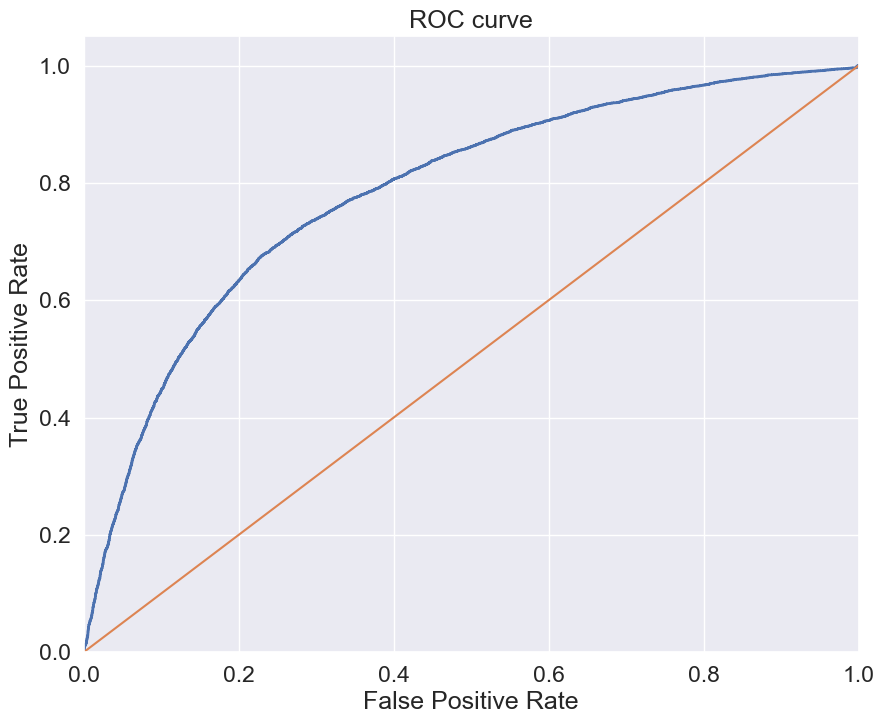

In [19]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_lr, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [20]:
roc_auc_score_lr = roc_auc_score(y_true=y_test, y_score=classifier_lr.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_lr))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_lr.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230662


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


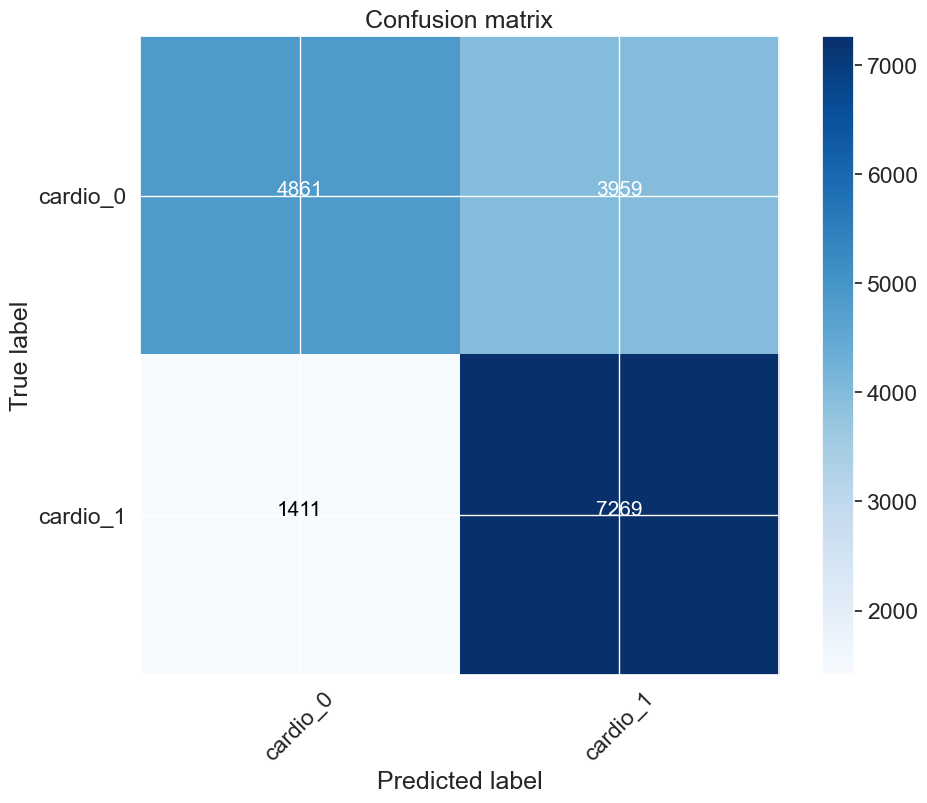

In [21]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, y_score_lr>thresholds[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_lr.png")
plt.show()

In [22]:
TN = cnf_matrix_lr[0][0]
FN = cnf_matrix_lr[1][0]
TP = cnf_matrix_lr[1][1]
FP = cnf_matrix_lr[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

#### Модель Random Forrest

In [23]:
%%time
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_rf = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_rf = np.mean(cv_scores_rf)
cv_score_std_rf = np.std(cv_scores_rf)
print('CV score is {}+-{}'.format(cv_score_rf, cv_score_std_rf))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7734501681056019+-0.007171140345435727
Wall time: 2min 42s


Посчитаем precision/recall/f_score

In [24]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

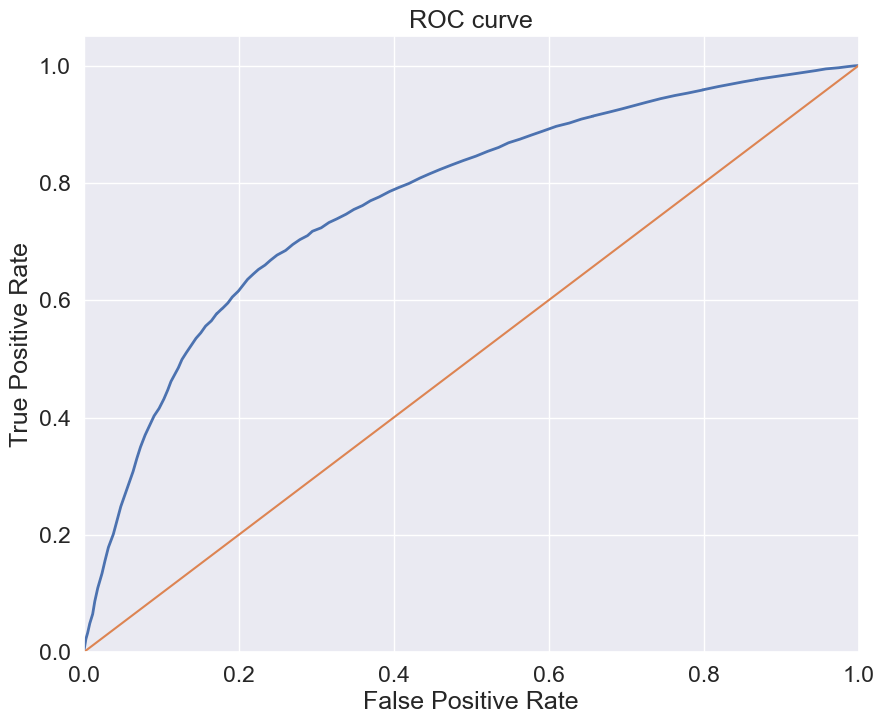

In [25]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_rf, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [26]:
roc_auc_score_rf = roc_auc_score(y_true=y_test, y_score=classifier_rf.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_rf))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_rf.predict_proba(X_test)[:,1])))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


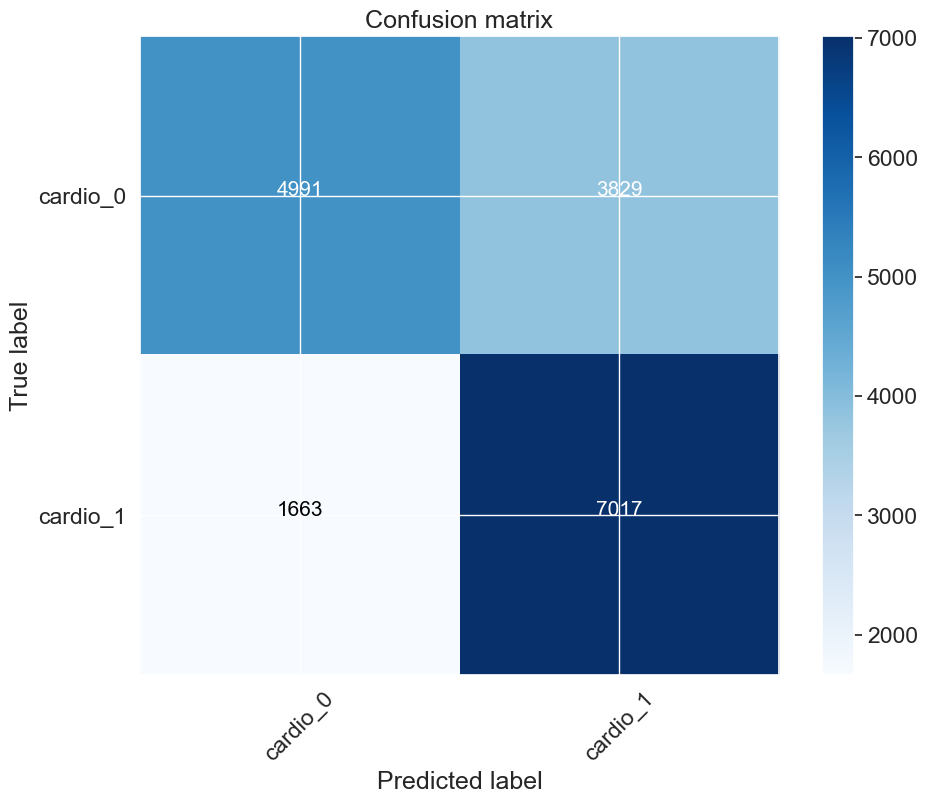

In [27]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_rf.png")
plt.show()

In [28]:
TN = cnf_matrix_rf[0][0]
FN = cnf_matrix_rf[1][0]
TP = cnf_matrix_rf[1][1]
FP = cnf_matrix_rf[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

#### Модель XGBoost

In [29]:
%%time
classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_xgb = cross_val_score(classifier_xgb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_xgb = np.mean(cv_scores_xgb)
cv_score_std_xgb = np.std(cv_scores_xgb)
print('CV score is {}+-{}'.format(cv_score_xgb, cv_score_std_xgb))

#обучим пайплайн на всем тренировочном датасете
classifier_xgb.fit(X_train, y_train)
y_score_xgb = classifier_xgb.predict_proba(X_test)[:, 1]

CV score is 0.7974879407860951+-0.006447877492510205
Wall time: 42.2 s


Посчитаем precision/recall/f_score

In [30]:
b=1
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test.values, y_score_xgb)
fscore_xgb = (1+b**2)*(precision_xgb * recall_xgb) / (b**2*precision_xgb + recall_xgb)
# locate the index of the largest f score
ix_xgb = np.argmax(fscore_xgb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_xgb[ix_xgb], 
                                                                        fscore_xgb[ix_xgb],
                                                                        precision_xgb[ix_xgb],
                                                                        recall_xgb[ix_xgb]))

Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

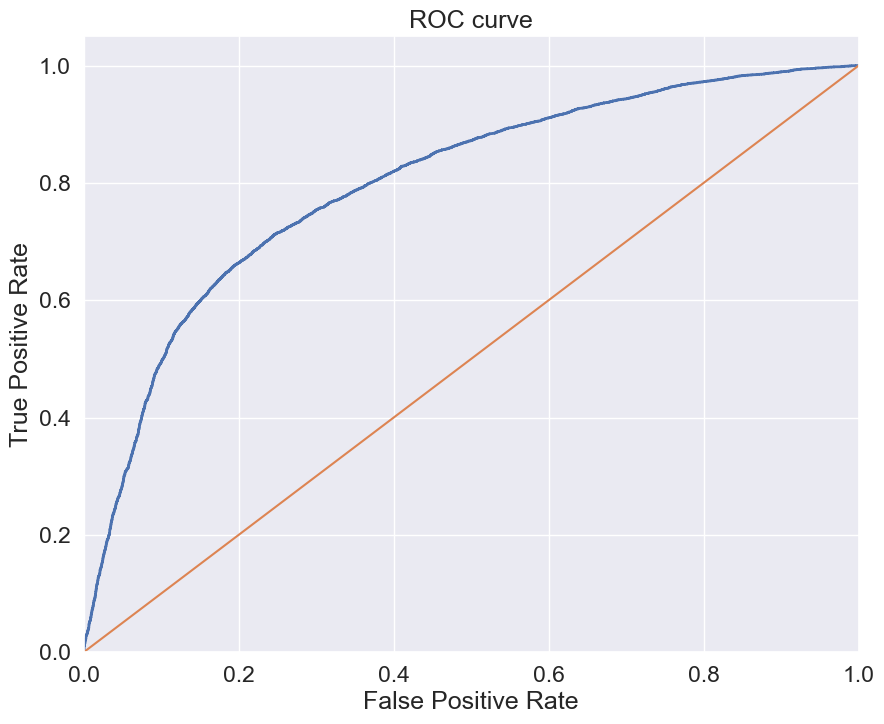

In [31]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_xgb, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [32]:
roc_auc_score_xgb = roc_auc_score(y_true=y_test, y_score=classifier_xgb.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_xgb))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_xgb.predict_proba(X_test)[:,1])))

roc auc score: 0.797227760535858
log loss score: 0.5471106091536182


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[5202 3618]
 [1491 7189]]


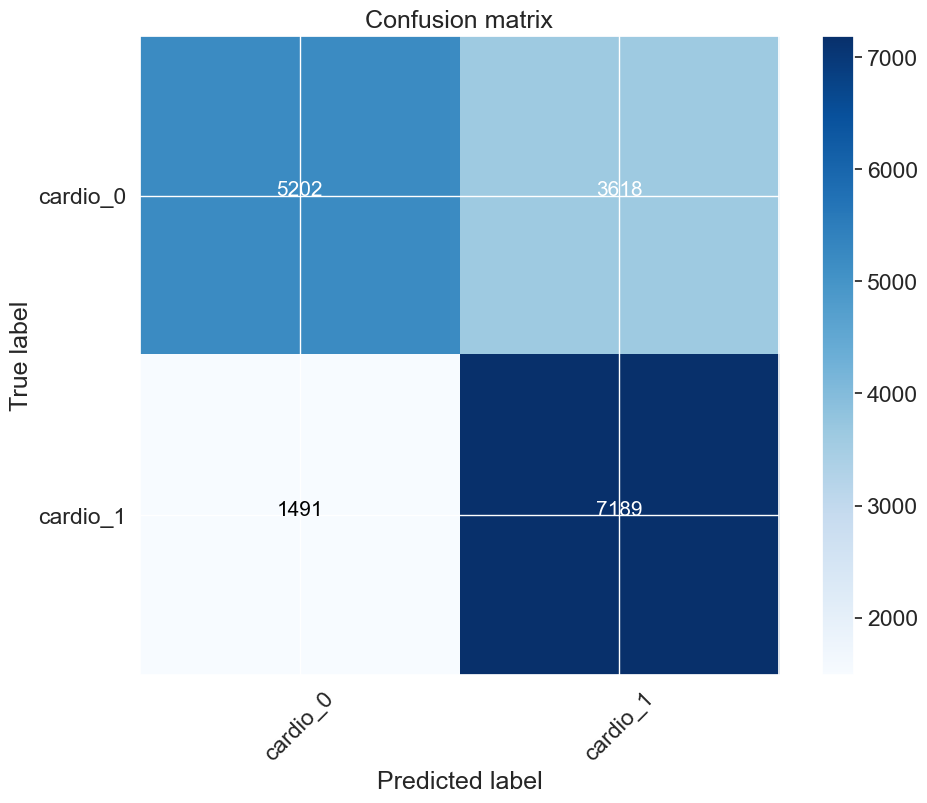

In [33]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_xgb = confusion_matrix(y_test, y_score_xgb>thresholds_xgb[ix_xgb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_xgb, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_xgb.png")
plt.show()

In [34]:
TN = cnf_matrix_xgb[0][0]
FN = cnf_matrix_xgb[1][0]
TP = cnf_matrix_xgb[1][1]
FP = cnf_matrix_xgb[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8282258064516129, 0.41020408163265304, 0.5897959183673469)

#### Сравнение моделей

In [62]:
data = [[fscore_lr[ix_lr], precision_lr[ix_lr], recall_lr[ix_lr], roc_auc_score_lr],
        [fscore_rf[ix_rf], precision_rf[ix_rf], recall_rf[ix_rf], roc_auc_score_rf],
        [fscore_xgb[ix_xgb], precision_xgb[ix_xgb], recall_xgb[ix_xgb], roc_auc_score_xgb]]

model_df = pd.DataFrame(data, index=['LogisticRegression', 'RandomForrest', 'XGBoost'], 
                        columns=['Fscore', 'Precision', 'Recall', 'ROC_AUC'])

In [63]:
model_df

,Fscore,Precision,Recall,ROC_AUC
LogisticRegression,0.730323,0.647431,0.837558,0.784035
RandomForrest,0.718863,0.642669,0.815553,0.771037
XGBoost,0.737890,0.665248,0.828341,0.797228


Исходя из полученной таблицы метрик можно сделать следующей вывод:
    
    Не смотря на то что показатель fscore для модели XGBoost выше чем для модели LogisticRegression все равно модель LoggisticRegression в данной стуации будет предпочтительна так как она более точно предсказывает TP для целевого класса 1, т.е. полнота ее выше что важно с точки зрения предсказания кардиопроблем. Правда нужно учесть что не проводился подбор гиперпараметров.
    Так же нужно учесть что модель XGBoost дала самый низкий FPR (41%) по сравнениею с LogisticRegression (~45%) и более высокий TNR (~59%) что говорит о большей точности модели XGBoost.
    Модель RandomForest так же по показателям FPR и TNR дала результаты лучше чем модель LogicticRegression.
    
    В целом выбор модели будет определяться ответом на вопросы что наиболее важно для решения задачи.